# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily, Hourly
import datetime
import seaborn as sns
import torch
import torch.nn as nn
from copy import deepcopy as dc

## 1. Data Exploration

In [2]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [3]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3391 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [4]:
visitor_data.describe()

,timestemp,value
count,4896,3391.000000
mean,2023-01-28 03:24:22.500000,2.693306
min,2022-03-28 09:30:00,0.000000
25%,2022-08-28 05:48:45,0.000000
50%,2023-01-28 02:07:30,1.000000
75%,2023-06-29 22:26:15,4.000000
max,2023-11-29 18:45:00,20.000000
std,NaN,3.474689


<Axes: xlabel='timestemp'>

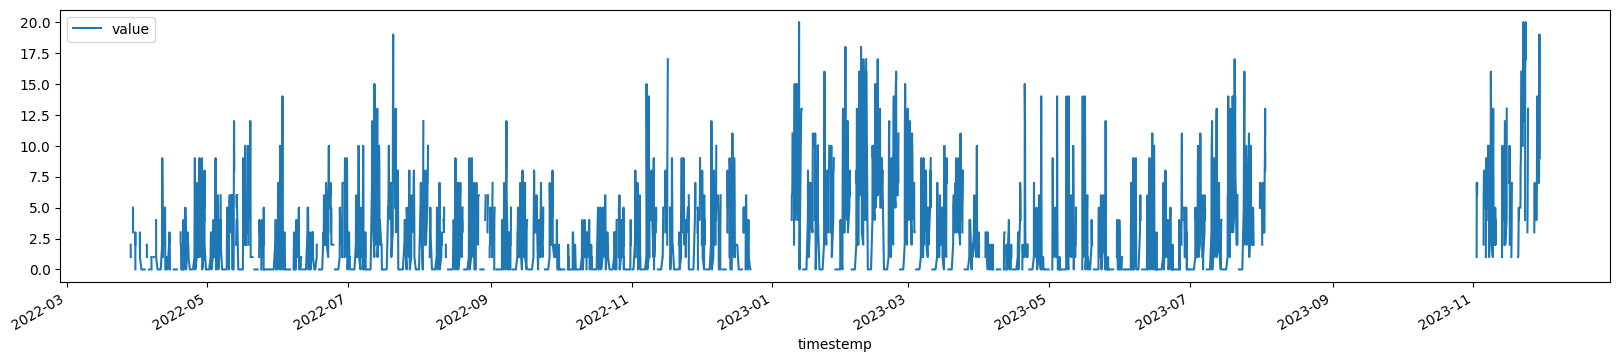

In [5]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 4))

## 2. Data Preprocessing

- Missing Values mit 
    - Median
    - k-Nearest Neighbors
- Holiday/Ferien/Feiertage
- Öffungzeiten: Mo. - Do. 09:00 - 19:00, Fr. 09:00 - 17:00
- drop all features that does'nt fit into the time
- Wochentage als zahlen darstellen pandas.dtday...


- Neue datenstruktur:
    - Firaz: ab August

In [6]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('timestemp', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'value (t-{i})'] = df['value'].shift(i)

    return df

lookback = 7
shifted_df = prepare_dateframe_for_lstm(visitor_data, lookback)
shifted_df

# wenn wir zei Wochen übergeben wollen, müssen wir 8*14=114 Werte zurück gehen...
# Die features wurden noch nicht dem df hinzugefüht !!!

,value,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7)
timestemp,,,,,,,,
2022-03-28 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 13:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-29 16:15:00,19.0,19.0,7.0,7.0,NaN,11.0,NaN,12.0
2023-11-29 17:45:00,9.0,19.0,19.0,7.0,7.0,NaN,11.0,NaN
2023-11-29 18:00:00,NaN,9.0,19.0,19.0,7.0,7.0,NaN,11.0


In [7]:
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

visitor_data

,timestemp,value,date
0,2022-03-28 09:30:00,NaN,2022-03-28
1,2022-03-28 10:45:00,NaN,2022-03-28
2,2022-03-28 13:45:00,NaN,2022-03-28
3,2022-03-28 16:15:00,NaN,2022-03-28
4,2022-03-28 17:45:00,NaN,2022-03-28
...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29
4892,2023-11-29 17:45:00,9.0,2023-11-29
4893,2023-11-29 18:00:00,NaN,2023-11-29
4894,2023-11-29 18:30:00,5.0,2023-11-29


In [8]:
# add column "weekday"
# fill "weekday" with weekdays in relation to the date
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"] 
visitor_data["weekday"] = [days[weekday] for weekday in visitor_data["timestemp"].dt.dayofweek]
visitor_data

,timestemp,value,date,weekday
0,2022-03-28 09:30:00,NaN,2022-03-28,monday
1,2022-03-28 10:45:00,NaN,2022-03-28,monday
2,2022-03-28 13:45:00,NaN,2022-03-28,monday
3,2022-03-28 16:15:00,NaN,2022-03-28,monday
4,2022-03-28 17:45:00,NaN,2022-03-28,monday
...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday


In [9]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 'saturday' or timestemp == 'sunday':
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
visitor_data

,timestemp,value,date,weekday,weekend
0,2022-03-28 09:30:00,NaN,2022-03-28,monday,0
1,2022-03-28 10:45:00,NaN,2022-03-28,monday,0
2,2022-03-28 13:45:00,NaN,2022-03-28,monday,0
3,2022-03-28 16:15:00,NaN,2022-03-28,monday,0
4,2022-03-28 17:45:00,NaN,2022-03-28,monday,0
...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday,0
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday,0
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday,0
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday,0


In [10]:
# Vorlesungspahse = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [11]:
visitor_data

exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
visitor_data

,timestemp,value,date,weekday,weekend,exam_phase
0,2022-03-28 09:30:00,NaN,2022-03-28,monday,0,1
1,2022-03-28 10:45:00,NaN,2022-03-28,monday,0,1
2,2022-03-28 13:45:00,NaN,2022-03-28,monday,0,1
3,2022-03-28 16:15:00,NaN,2022-03-28,monday,0,1
4,2022-03-28 17:45:00,NaN,2022-03-28,monday,0,1
...,...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday,0,0
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday,0,0
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday,0,0
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday,0,0


In [12]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])
# today_hour = int(str(datetime.datetime.today())[11:13])
# today_min = int(str(datetime.datetime.today())[14:16])
# today_sec = int(str(datetime.datetime.today())[17:19])

# # get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# # Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-16,5.1,1.3,7.5,0.0,0.0,156.0,3.6,19.4,1042.3,48.0
2023-12-17,2.7,-0.1,7.3,0.0,NaN,150.0,8.3,19.0,1040.7,NaN
2023-12-18,2.8,0.2,6.3,0.0,NaN,166.0,8.2,16.7,1035.8,NaN


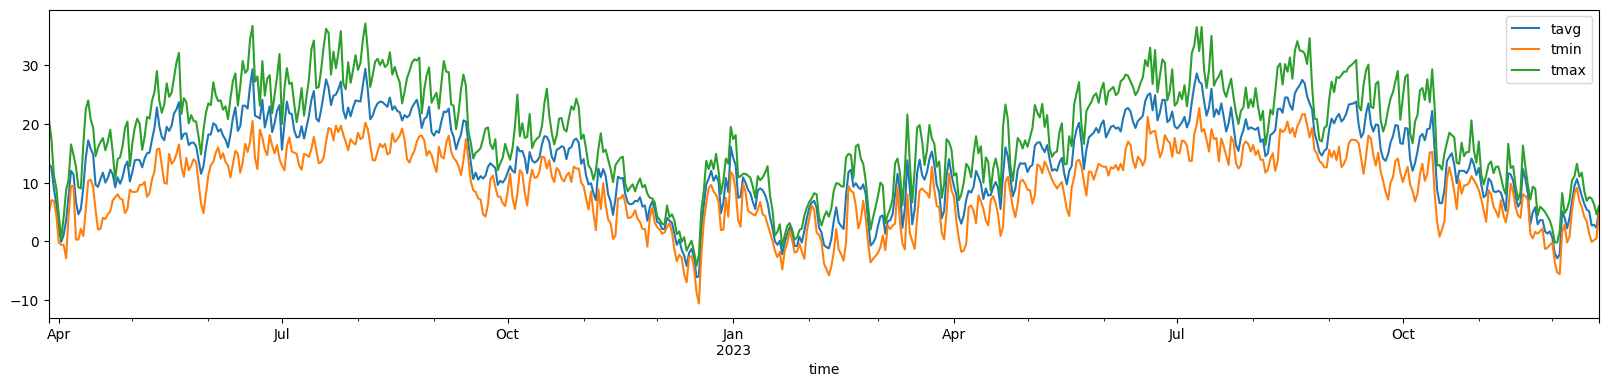

In [13]:
weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
plt.show()

In [14]:
# merge data frames
joined_df = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time" # Die Uhrzeiten müssen auch passen | Muss man fixen
)

joined_df

,timestemp,value,date,weekday,weekend,exam_phase,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-03-28 09:30:00,NaN,2022-03-28,monday,0,1,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
1,2022-03-28 10:45:00,NaN,2022-03-28,monday,0,1,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2,2022-03-28 13:45:00,NaN,2022-03-28,monday,0,1,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
3,2022-03-28 16:15:00,NaN,2022-03-28,monday,0,1,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
4,2022-03-28 17:45:00,NaN,2022-03-28,monday,0,1,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday,0,0,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday,0,0,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday,0,0,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday,0,0,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [15]:
#calculate correlations between all features of your data frame (see Exploration lab)
data_corr = joined_df.corr()
print(joined_df)

# Displaying correlations as a heatmap / correlation matrix 
joined_df.style.background_gradient(cmap='coolwarm')

ValueError: could not convert string to float: 'monday'

## 3. Prepare Data for Model

In [ ]:
joined_df.shape

(4896, 16)

In [ ]:
data_array = joined_df.to_numpy()

data_array

array([[Timestamp('2022-03-28 09:30:00'), nan,
        Timestamp('2022-03-28 00:00:00'), ..., 30.6, 1021.4, 630.0],
       [Timestamp('2022-03-28 10:45:00'), nan,
        Timestamp('2022-03-28 00:00:00'), ..., 30.6, 1021.4, 630.0],
       [Timestamp('2022-03-28 13:45:00'), nan,
        Timestamp('2022-03-28 00:00:00'), ..., 30.6, 1021.4, 630.0],
       ...,
       [Timestamp('2023-11-29 18:00:00'), nan,
        Timestamp('2023-11-29 00:00:00'), ..., 29.5, 1007.5, 72.0],
       [Timestamp('2023-11-29 18:30:00'), 5.0,
        Timestamp('2023-11-29 00:00:00'), ..., 29.5, 1007.5, 72.0],
       [Timestamp('2023-11-29 18:45:00'), nan,
        Timestamp('2023-11-29 00:00:00'), ..., 29.5, 1007.5, 72.0]],
      dtype=object)

In [ ]:
data_array.shape

(4896, 16)

## 4. Build Model